In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm
from tensorly.base import unfold

np.random.seed(14159)

In [2]:
# Set parameters
n = np.array([600, 400, 200])
beta_M = 1.5
rho_T = 2

In [3]:
# Define variables
setting = "$\mathbf{{n}} = {{{}}}^\\top \\quad \\rho_T = {{{}}} \\quad \\beta_M = {{{}}}$".format(list(n), np.round(rho_T, 2), np.round(beta_M, 2))

n_T = n[0]+n[1]+n[2]
n_M = n[0]+n[1]
c = n/n_T

beta_T = np.sqrt(rho_T*np.sqrt(n[0]*n[1]*n[2])/n_T)

# Set model
x, y, z = (np.random.randn(n[ell]) for ell in range(3))
x /= linalg.norm(x)
y /= linalg.norm(y)
z /= linalg.norm(z)

Z = np.random.randn(n[0], n[1])
W = np.random.randn(*n)

M = beta_M*np.einsum('i,j->ij', x, y)+Z/np.sqrt(n_M)
T = beta_T*np.einsum('ij,k->ijk', M, z)+W/np.sqrt(n_T)

In [4]:
eigvalsM = linalg.eigvalsh(M.T@M) # eigenvalues of M^T M

T2 = unfold(T, 1)
eigvals, eigvecs = linalg.eigh(T2@T2.T) # eigenvalues and eigenvectors of T2 T2^T

In [5]:
# LSD and spikes of M^T M
Em, Ep = (c[0]+c[1]-2*np.sqrt(c[0]*c[1]))/(1-c[2]), (c[0]+c[1]+2*np.sqrt(c[0]*c[1]))/(1-c[2])
def g(z):
    plus = (-z+(c[0]-c[1])/(1-c[2])+np.sqrt((z-Em)*(z-Ep)))/(2*c[1]*z/(1-c[2]))
    minus = (-z+(c[0]-c[1])/(1-c[2])-np.sqrt((z-Em)*(z-Ep)))/(2*c[1]*z/(1-c[2]))
    return np.where(z.imag*plus.imag < 0, minus, plus)
ksi_M = (beta_M**2+c[0]/(1-c[2]))*(beta_M**2+c[1]/(1-c[2]))/beta_M**2

In [6]:
# LSD and spikes of T2 T2^T
def m(z):
    roots = np.roots([rho_T*c[1]/(1-c[2]), 1+z*rho_T*c[1]/(1-c[2]), z+rho_T*(c[1]-c[0])/(1-c[2]), 1])
    return roots[roots.imag*z.imag > 0][0]
a1 = rho_T*c[0]/(1-c[2])+rho_T*beta_M**2
a2 = rho_T*c[1]/(1-c[2])+rho_T*beta_M**2
ksi = a1*a2/(rho_T*beta_M**2)+1/a2
zeta = 1-(((rho_T*beta_M**2)/a2)**2+(rho_T*c[1]/(1-c[2]))*a1)/(a2*rho_T*beta_M**2)

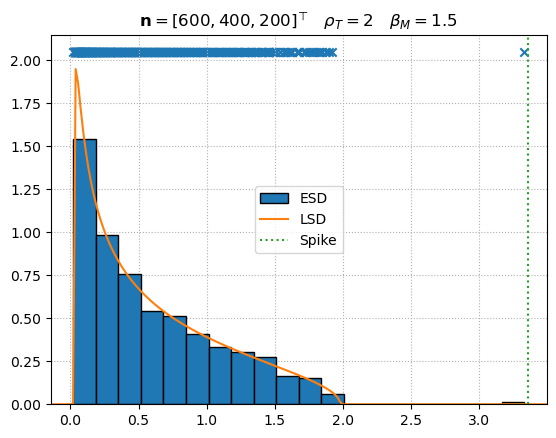

In [7]:
plt.hist(eigvalsM, bins='sqrt', edgecolor='black', density=True, zorder=2, label="ESD")
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 200)
LSD = g(xx+1e-5j).imag/np.pi
plt.plot(xx, LSD, color='C1', label="LSD")
_, ymax = plt.ylim()
plt.scatter(eigvalsM, [ymax]*n[1], marker='x')
plt.axvline(ksi_M, ls=':', color='C2', label="Spike")
plt.grid(ls=':')
plt.xlim(xmin, xmax)
plt.title(setting)
plt.legend()
plt.show()

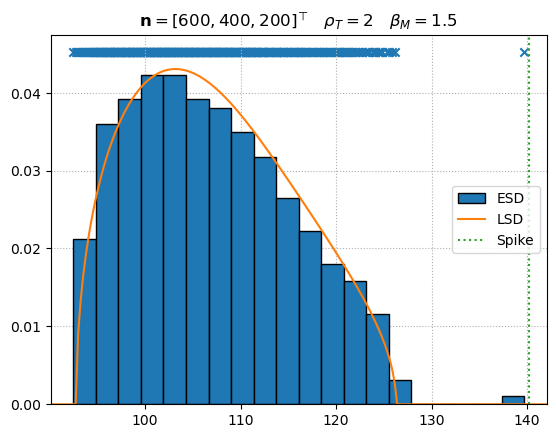

In [8]:
plt.hist(eigvals, bins='sqrt', edgecolor='black', density=True, zorder=2, label="ESD")
xmin, xmax = plt.xlim()
xx = np.linspace(xmin, xmax, 200)
mm = np.array([m(x+1e-8j) for x in (n_T*xx-(n[1]+n[0]*n[2]))/np.sqrt(n[0]*n[1]*n[2])])
LSD = n_T*mm.imag/(np.pi*np.sqrt(n[0]*n[1]*n[2]))
plt.plot(xx, LSD, color='C1', label="LSD")
_, ymax = plt.ylim()
plt.scatter(eigvals, [ymax]*n[1], marker='x')
plt.axvline((np.sqrt(n[0]*n[1]*n[2])*ksi+n[1]+n[0]*n[2])/n_T, color='C2', ls=':', label="Spike")
plt.grid(ls=':')
plt.xlim(xmin, xmax)
plt.title(setting)
plt.legend()
plt.show()

In [9]:
# Alignment as a function of beta_M and rho_T
def align(b, r):
    a1 = c[0]/(1-c[2])+b**2
    a2 = c[1]/(1-c[2])+b**2
    zeta = 1-((b**2/(r*a2))**2+c[1]*a1/(1-c[2]))/(a2*b**2)
    return zeta if zeta > 0 else np.nan

bb = np.linspace(0, 5, 1001)[1:]
rr = np.linspace(0, 5, 1001)[1:]
aa = np.zeros((len(bb), len(rr)))
for i, b in enumerate(tqdm(bb)):
    for j, r in enumerate(rr):
        aa[i, j] = align(b, r)

# Phase transition curve
pht = 1e12*np.ones(len(bb))
mask = (bb**4 > c[0]*c[1]/(1-c[2]))
pht[mask] = bb[mask]**2/((c[1]/(1-c[2])+bb[mask]**2)*np.sqrt(bb[mask]**4-c[0]*c[1]/(1-c[2])))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 206.90it/s]


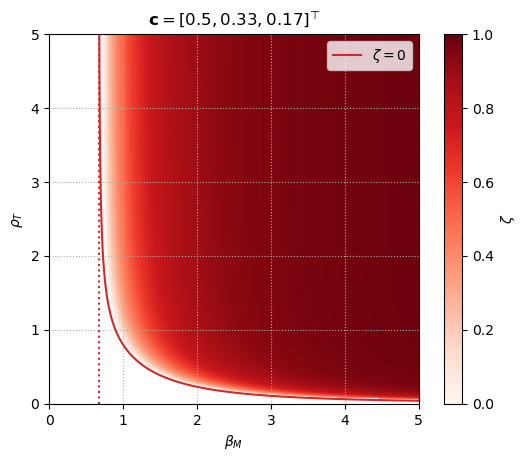

In [10]:
plt.colorbar(plt.imshow(aa.T, origin='lower', extent=[bb[0], bb[-1], rr[0], rr[-1]], vmin=0, vmax=1, cmap='Reds'), label="$\\zeta$")
plt.plot(bb, pht, color='C3', label="$\\zeta = 0$")
plt.axvline((c[0]*c[1]/(1-c[2]))**.25, ls=':', color='C3')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("$\\beta_M$")
plt.ylabel("$\\rho_T$")
plt.title("$\mathbf{{c}} = {{{}}}^\\top$".format(list(np.round(c, 2))))
plt.grid(ls=':')
plt.legend()
plt.show()